# Material sobre datasets desbalanceados

Datasets desbalanceados ocorrem quando temos um dataset que possui muitos exemplos de uma classe e poucos exemplos de outra classe. Alguns exemplos de situações onde o desbalanceamento é quase certo são problemas de detecção de fraude e diagnóstico médicos – é intuitivo pensar que existem mais transações lícitas que criminosas, ou que o conjunto de pessoas diagnosticadas com câncer é bem menor que o conjunto de pessoas sem a doença.

Considere o dataset sintético abaixo:

In [2]:
import pandas as pd
from sklearn.datasets import make_classification
X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.99, 0.01],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=10000, random_state=10
)
df = pd.DataFrame(X)
df['target'] = y
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,-1.655240,-0.147198,0.415068,0.403287,-0.838969,-0.710579,0.669914,0.349415,0.411229,-0.524709,...,-0.886677,0.008313,0.133057,-0.422450,-0.751846,0.310938,1.090738,-1.170717,-1.144163,0
1,0.664089,0.796450,1.136533,-0.584531,-1.234181,0.247015,1.195855,0.074378,0.024109,0.157357,...,0.645870,-1.131955,-1.088485,1.230223,-1.543503,1.201179,1.747610,-1.921932,-0.272518,0
2,-0.573594,-1.132047,-0.358793,0.988715,-2.019066,-1.431532,0.452350,0.773375,0.275413,-2.064601,...,-0.364147,-0.439066,0.266009,0.213619,-2.242023,-0.047062,2.032065,-3.269606,0.678143,0
3,-0.160255,0.402425,-1.712775,1.235039,-0.855401,0.730973,-1.266879,0.060664,-1.081172,-0.950357,...,-1.197636,-0.180489,1.765828,0.836075,-1.383372,0.665599,0.964300,-1.596423,0.341733,0
4,0.909147,-2.191779,0.213128,-0.335295,-0.789976,1.808119,0.507753,0.032192,-0.746902,0.604907,...,1.492470,0.060965,1.162961,0.829912,-1.785085,1.767214,1.148502,-1.674123,1.319652,0


In [3]:
df['target'].value_counts()

0    9900
1     100
Name: target, dtype: int64

Digamos que o valor 1 da variável *target* são transações fraudulentas e o valor 0 são transações não fraudulentas. Dado a distribuição de exemplos (apenas 1\% das transações são fraudulentas) é possível perceber que trata-se de um dataset não balanceado. 

## Métrica

O primeiro problema que temos com este tipo de dataset é a métrica a ser usada para avaliar a qualidade do modelo. Por exemplo, não podemos usar acurácia. Imagine uma função de predição extremamente simples que considera todos os exemplos como sendo da categoria majoritária (0): 

In [4]:
predicted = df.apply(lambda x: 0,axis=1)

In [6]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(df['target'], predicted))
from sklearn.metrics import classification_report
print(classification_report(df['target'], predicted))

[[9900    0]
 [ 100    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9900
           1       0.00      0.00      0.00       100

    accuracy                           0.99     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.98      0.99      0.99     10000



/Users/fabricio/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A acurácia retornada para esta função é de 99\%! Bem alto certo? Mas, este modelo consegue identificar o que queremos identificar? **Não!**

Sendo assim, temos que considerar outra métrica. Por exemplo, **f1-score** e informar que a classe de interesse é a com valor igual a 1:

In [7]:
from sklearn.metrics import f1_score
print(f1_score(df['target'], predicted, pos_label=1))

0.0


Neste caso conseguimos perceber o quão ruim é este modelo. Vamos tentar com um modelo mais sofisticado:

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1-score: %.2f%%" % (f1 * 100.0))
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

f1-score: 84.44%
accuracy: 99.65%
[[1974    1]
 [   6   19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1975
           1       0.95      0.76      0.84        25

    accuracy                           1.00      2000
   macro avg       0.97      0.88      0.92      2000
weighted avg       1.00      1.00      1.00      2000



Neste caso, o resultado foi muito melhor do que o primeiro modelo. Pois, saimos de f1-score igual a zero para f1-score igual a 84.44\%

## Abordagens

As abordagens para tratamento de datasets desbalanceados são: 

* over-sampling, e;
* under-sampling

São métodos que equalizam a quantidade de exemplos de cada classe no conjunto de treinamento. Em outras palavras, ou ele irá diminuir a quantidade de observações da classe majoritária, ou irá aumentar as observações da classe minoritária.

### Implementando under-sampling

In [12]:
# CONTAR CLASSES
df_train = pd.DataFrame(X_train)
df_train['target'] = y_train
print('dataset original')
print(df_train['target'].value_counts())

count_class_0, count_class_1 = df_train.target.value_counts()
# Divide by class
df_train_class_0 = df_train[df_train['target'] == 0]
df_train_class_1 = df_train[df_train['target'] == 1]

df_train_class_0_under = df_train_class_0.sample(count_class_1)

df_train_under = pd.concat([df_train_class_0_under, df_train_class_1], axis=0)
df_train_under['target'].value_counts()
print('dataset transformado')
print(df_train_under['target'].value_counts())

dataset original
0    7925
1      75
Name: target, dtype: int64
dataset transformado
1    75
0    75
Name: target, dtype: int64


In [13]:
# soh o conjunto de treinamento eh under-sampling
y_under = df_train_under['target']
df_train_under = df_train_under.drop(columns=['target'])
model.fit(df_train_under, y_under)

GradientBoostingClassifier()

In [14]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1-score: %.2f%%" % (f1 * 100.0))
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

f1-score: 22.32%
accuracy: 91.30%
[[1801  174]
 [   0   25]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1975
           1       0.13      1.00      0.22        25

    accuracy                           0.91      2000
   macro avg       0.56      0.96      0.59      2000
weighted avg       0.99      0.91      0.94      2000



### Implementando over-sampling

In [15]:
# CONTAR CLASSES
df_train = pd.DataFrame(X_train)
df_train['target'] = y_train
print('dataset original')
print(df_train['target'].value_counts())

count_class_0, count_class_1 = df_train.target.value_counts()
# Divide by class
df_train_class_0 = df_train[df_train['target'] == 0]
df_train_class_1 = df_train[df_train['target'] == 1]

df_train_class_1_over = df_train_class_1.sample(count_class_0, replace=True)

df_train_over = pd.concat([df_train_class_0, df_train_class_1_over], axis=0)
print('dataset transformado')
df_train_over['target'].value_counts()

dataset original
0    7925
1      75
Name: target, dtype: int64
dataset transformado


1    7925
0    7925
Name: target, dtype: int64

In [16]:
# soh o conjunto de treinamento eh over-sampling
y_over = df_train_over['target']
df_train_over = df_train_over.drop(columns=['target'])
model.fit(df_train_over, y_over)

GradientBoostingClassifier()

In [17]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1-score: %.2f%%" % (f1 * 100.0))
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

f1-score: 83.33%
accuracy: 99.60%
[[1972    3]
 [   5   20]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1975
           1       0.87      0.80      0.83        25

    accuracy                           1.00      2000
   macro avg       0.93      0.90      0.92      2000
weighted avg       1.00      1.00      1.00      2000



### SMOTE: um tipo especial de over-sampling (SMOTE: synthetic minority over-sampling technique)

Primeiro passo é encontrar os vizinhos próximos para cada exemplo da classe minoritária. Em seguida, o algoritmo traça uma reta entre o ponto original e o vizinho para definir o exemplo sintético a ser gerado.


In [18]:
print(X_train.shape)
print(y_train.shape)
from collections import Counter
print(Counter(y_train))

(8000, 20)
(8000,)
Counter({0: 7925, 1: 75})


In [20]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

sm = SMOTE(random_state=1234)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(X_train_res.shape)
print(y_train_res.shape)
print(Counter(y_train_res))

(15850, 20)
(15850,)
Counter({0: 7925, 1: 7925})


In [21]:
model = GradientBoostingClassifier()
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1-score: %.2f%%" % (f1 * 100.0))
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

f1-score: 72.13%
accuracy: 99.15%
[[1961   14]
 [   3   22]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1975
           1       0.61      0.88      0.72        25

    accuracy                           0.99      2000
   macro avg       0.80      0.94      0.86      2000
weighted avg       0.99      0.99      0.99      2000



### Usando algoritmos que fazem under-sample ou over-sample internamente

In [52]:
from imblearn.ensemble import BalancedRandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict

min_estimators = 100
max_estimators = 2000
step = 100
result = []
for i in range(min_estimators, max_estimators+step, step):
    clf = BalancedRandomForestClassifier(n_estimators=i, max_depth=None, random_state=0)
    s = make_scorer(f1_score, pos_label=1)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=s)
    result.append((i, scores.mean()))

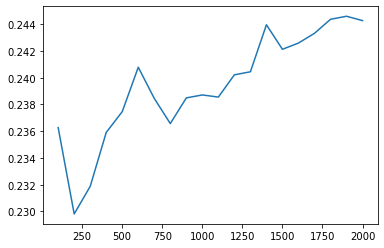

In [53]:
import matplotlib.pyplot as plt
plt.plot(*zip(*result))

In [54]:
max(result,key=lambda item:item[1])

(1900, 0.24458980050081744)

In [55]:
model = BalancedRandomForestClassifier(n_estimators=4000, max_depth=None, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1-score: %.2f%%" % (f1 * 100.0))
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

f1-score: 27.12%
accuracy: 93.55%
[[1847  128]
 [   1   24]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1975
           1       0.16      0.96      0.27        25

    accuracy                           0.94      2000
   macro avg       0.58      0.95      0.62      2000
weighted avg       0.99      0.94      0.96      2000



## Referências

* [SMOTE](../../references/smote.pdf)
* [BalancedRandomForestClassifier](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html)

